In [1]:
import numpy as np
import os
import json_lines
import codecs
from keras_bert import load_trained_model_from_checkpoint, Tokenizer

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
pretrained_path = 'pretrained/uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [3]:
SEQ_LEN = 128
BATCH_SIZE = 25
EPOCHS = 5
LR = 5e-6

In [4]:
bert_model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,
)

In [5]:
class Tokeniser(Tokenizer):
    def __init__(self, dict_path):
        token_dict = {}
        with codecs.open(dict_path, 'r', 'utf8') as reader:
            for line in reader:
                token = line.strip()
                token_dict[token] = len(token_dict)
        super().__init__(token_dict)

def load_data(tokenizer: Tokeniser, file_path,
    text_label='trans_en', target_label='voted_up', max_len=100, batch_size=20):
    indices, sentiments = [], []
    with open(file_path, 'rb') as f:
        for item in json_lines.reader(f):
            ids, segments = tokenizer.encode(item[text_label].lower(), max_len=max_len)
            indices.append(ids)
            sentiments.append(int(item[target_label]))
    items = list(zip(indices, sentiments))
    np.random.shuffle(items)
    indices, sentiments = zip(*items)
    indices = np.array(indices)
    mod = indices.shape[0] % batch_size
    if mod > 0:
        indices, sentiments = indices[:-mod], sentiments[:-mod]
    return indices, np.array(sentiments)

In [6]:
def get_model():
    inputs = bert_model.inputs[:2]
    dense = bert_model.get_layer('NSP-Dense').output
    outputs = Dense(units=2, activation='softmax')(dense)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(LR),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )
    return model

In [7]:
tokeniser = Tokeniser(vocab_path)

In [8]:
def model_train(model, target_label='voted_up', model_name='bert_voted_up'):
    X, y = load_data(tokeniser, 'data/reviews_112_trans-en.jl',
        target_label=target_label, max_len=SEQ_LEN, batch_size=BATCH_SIZE)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    mcp_save = ModelCheckpoint("result/"+model_name+'.best.h5',
        save_best_only=True, monitor='val_sparse_categorical_accuracy', mode='max')
    model.fit(
        [X_train, np.zeros_like(X_train)],
        y_train,
        epochs=EPOCHS,
        validation_split=0.1,
        batch_size=BATCH_SIZE,
        callbacks=[EarlyStopping(monitor='val_loss', patience=4), mcp_save]
    )
    model.save_weights("result/"+model_name+".h5")

# BERT Voted up

In [9]:
model = get_model()
model_train(model, 'voted_up', 'bert_voted_up')

Epoch 1/5
162/162 [==============================] - 142s 875ms/step - loss: 0.5234 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.4685 - val_sparse_categorical_accuracy: 0.7689
Epoch 2/5
162/162 [==============================] - 140s 864ms/step - loss: 0.3682 - sparse_categorical_accuracy: 0.8304 - val_loss: 0.4284 - val_sparse_categorical_accuracy: 0.8067
Epoch 3/5
162/162 [==============================] - 127s 783ms/step - loss: 0.2809 - sparse_categorical_accuracy: 0.8830 - val_loss: 0.4585 - val_sparse_categorical_accuracy: 0.8022
Epoch 4/5
162/162 [==============================] - 128s 791ms/step - loss: 0.2084 - sparse_categorical_accuracy: 0.9178 - val_loss: 0.4910 - val_sparse_categorical_accuracy: 0.7867
Epoch 5/5
162/162 [==============================] - 127s 784ms/step - loss: 0.1505 - sparse_categorical_accuracy: 0.9474 - val_loss: 0.5354 - val_sparse_categorical_accuracy: 0.8067


Evaluation

In [10]:
import json
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [11]:
def plot_roc(pred, y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    try:
        auc = roc_auc_score(y, pred)
    except ValueError:
        auc = "undefined"

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.plot(fpr, tpr, color='red')
    ax.plot([0,1], [0,1], color='black', linestyle='--')
    ax.set_title(f"AUC: {auc}")

In [12]:
model.load_weights("result/bert_voted_up.best.h5")

In [13]:
X, y = load_data(tokeniser, 'data/reviews_112_trans-en.jl',
        target_label='voted_up', max_len=SEQ_LEN, batch_size=BATCH_SIZE)
preds = model.predict([X, np.zeros_like(X)], verbose=True, batch_size=BATCH_SIZE)
result_max = preds.argmax(axis=-1)
tn, fp, fn, tp = confusion_matrix(y, result_max).ravel()

print('Confusion matrix:')
print('[{}, {}]'.format(tp, fp))
print('[{}, {}]'.format(fn, tn))

200/200 [==============================] - 46s 231ms/step
Confusion matrix:
[2242, 319]
[258, 2181]


In [14]:
print('Accuracy: %.4f' % accuracy_score(y, result_max))

Accuracy: 0.8846


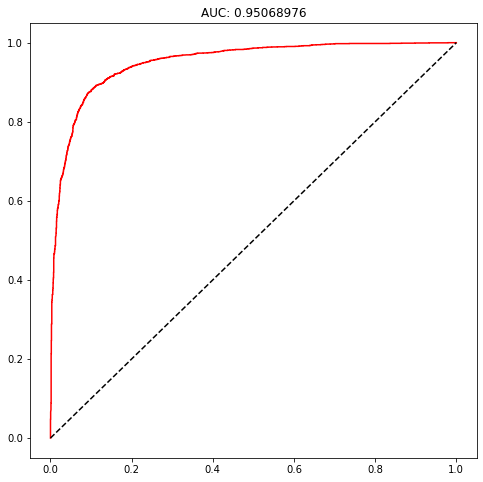

In [15]:
plot_roc(preds[:,1], y)